In [1]:
from oda_api.api import DispatcherAPI
from oda_api.plot_tools import OdaImage,OdaLightCurve
from oda_api.data_products import BinaryData
import os
from astropy.io import fits
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
source_name='3C 279'
ra=194.046527
dec=-5.789314
radius=10.
Tstart='2003-03-15T00:00:00'
Tstop='2015-12-26T00:00:00'
host='www.astro.unige.ch/cdci/astrooda'
rebin=5 # minimal significance in energy bin, for spectral plotting

In [3]:
token=input() # token for restricted access server
cookies=dict(_oauth2_proxy=token)

In [4]:
disp=DispatcherAPI(host=host+'/dispatch-data',instrument='mock',cookies=cookies,protocol='https')

In [5]:
import requests
url="https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/"
def queryxtime(**args):
    params=Tstart+'/'+Tstop+'?&ra='+str(ra)+'&dec='+str(dec)+'&radius='+str(radius)+'&min_good_isgri=1000&index_version=20190904083708'
    print(url+params)
    return requests.get(url+params,cookies=cookies).json()

In [6]:
#if token!='':
scwlist=queryxtime()
m=len(scwlist)
pointings=[]
for i in range(m):
    if scwlist[i][-2:]=='10':
        pointings.append(scwlist[i]+'.001')
#else:
#    pointings=np.genfromtxt('scws_3C279_isgri_10deg.txt', dtype='str')
m=int(len(pointings)/50.)
print(m)

https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/2003-03-15T00:00:00/2015-12-26T00:00:00?&ra=194.046527&dec=-5.789314&radius=10.0&min_good_isgri=1000&index_version=20190904083708
21


In [7]:
scw_lists=[]
for i in range(m):
    count=0
    scw_string=''
    while(count<50):
        scw_string=scw_string+str(pointings[50*i+count])+','
        count+=1
    scw_lists.append(scw_string[:-1])


In [8]:
data=disp.get_product(instrument='isgri',
                      product='isgri_image',
                      scw_list=scw_lists[0],
                      E1_keV=20.0,
                      E2_keV=40.0,
                      osa_version='OSA10.2',
                      RA=ra,
                      DEC=dec,
                      detection_threshold=3.5,
                      product_type='Real')

007700160010.001,007700170010.001,007700180010.001,007700190010.001,007700200010.001,007700210010.001,007700220010.001,007700230010.001,007700240010.001,007700250010.001,007700260010.001,007700270010.001,007700280010.001,007700290010.001,007700300010.001,007700310010.001,007700320010.001,007700330010.001,007700340010.001,007700350010.001,007700360010.001,007700370010.001,007700380010.001,007700390010.001,007700400010.001,007700410010.001,007700460010.001,007700470010.001,007700480010.001,007700490010.001,007700500010.001,007700510010.001,007700520010.001,007700530010.001,007700540010.001,007700550010.001,007700560010.001,007700570010.001,007700580010.001,007700590010.001,007700600010.001,007700660010.001,007700670010.001,007800020010.001,007800030010.001,007800040010.001,007800050010.001,007800060010.001,007800070010.001,007800080010.001
- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
scw_list 007700160010.001,007700170010.

In [9]:
data.dispatcher_catalog_1.table

meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str15,float64,float64,float64,int64,int64,int64,float64
1,3C 273,14.710943222045898,187.28558349609375,2.062849283218384,-32768,2,0,0.0002800000074785203
29,IGR J12319-0749,3.997325897216797,187.99046325683594,-7.788333415985107,-32768,1,0,0.00027777778450399637
30,IGR J12391-1612,3.970698595046997,189.77621459960938,-16.179750442504883,-32768,2,0,0.00016999999934341758
50,NGC 4593,14.982671737670898,189.9297637939453,-5.368626594543457,-32768,2,0,0.0002800000074785203
57,NGC 5506,3.650805711746216,213.31195068359375,-3.2074999809265137,-32768,2,0,0.0002800000074785203


In [10]:
FLAG=0
torm=[]
for ID,n in enumerate(data.dispatcher_catalog_1.table['src_names']):
    if(n[0:2]=='NEW'):
        torm.append(ID)
    if(n==source_name):
        FLAG=1
data.dispatcher_catalog_1.table.remove_rows(torm)
nrows=len(data.dispatcher_catalog_1.table['src_names'])

In [11]:
if FLAG==0:
    data.dispatcher_catalog_1.table.add_row()
    data.dispatcher_catalog_1.table['src_names'][nrows]='3C 279'
    data.dispatcher_catalog_1.table['ra'][nrows]=ra
data.dispatcher_catalog_1.table['dec'][nrows]=dec
data.dispatcher_catalog_1.table['ISGRI_FLAG'][nrows]=2

data.dispatcher_catalog_1.table


meta_ID,src_names,significance,ra,dec,NEW_SOURCE,ISGRI_FLAG,FLAG,ERR_RAD
,,,deg,deg,,,,
int64,str15,float64,float64,float64,int64,int64,int64,float64
1,3C 273,14.710943222045898,187.28558349609375,2.062849283218384,-32768,2,0,0.0002800000074785203
29,IGR J12319-0749,3.997325897216797,187.99046325683594,-7.788333415985107,-32768,1,0,0.00027777778450399637
30,IGR J12391-1612,3.970698595046997,189.77621459960938,-16.179750442504883,-32768,2,0,0.00016999999934341758
50,NGC 4593,14.982671737670898,189.9297637939453,-5.368626594543457,-32768,2,0,0.0002800000074785203
57,NGC 5506,3.650805711746216,213.31195068359375,-3.2074999809265137,-32768,2,0,0.0002800000074785203
0,3C 279,0.0,194.046527,-5.789314,0,2,0,0.0


In [12]:
api_cat=data.dispatcher_catalog_1.get_api_dictionary()

In [13]:
spectrum_results=[]
for i in range(len(scw_lists)):
    print(i)
    data=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        scw_list=scw_lists[i],
                        query_type='Real',
                        osa_version='OSA10.2',
                        RA=ra,
                        DEC=dec,
                        product_type='Real',
                        selected_catalog=api_cat)
    spectrum_results.append(data)

0
007700160010.001,007700170010.001,007700180010.001,007700190010.001,007700200010.001,007700210010.001,007700220010.001,007700230010.001,007700240010.001,007700250010.001,007700260010.001,007700270010.001,007700280010.001,007700290010.001,007700300010.001,007700310010.001,007700320010.001,007700330010.001,007700340010.001,007700350010.001,007700360010.001,007700370010.001,007700380010.001,007700390010.001,007700400010.001,007700410010.001,007700460010.001,007700470010.001,007700480010.001,007700490010.001,007700500010.001,007700510010.001,007700520010.001,007700530010.001,007700540010.001,007700550010.001,007700560010.001,007700570010.001,007700580010.001,007700590010.001,007700600010.001,007700660010.001,007700670010.001,007800020010.001,007800030010.001,007800040010.001,007800050010.001,007800060010.001,007800070010.001,007800080010.001
007700160010.001,007700170010.001,007700180010.001,007700190010.001,007700200010.001,007700210010.001,007700220010.001,007700230010.001,007700240010

 | the job is working remotely, please wait status=done - job_id=4513146323537361919 1919 

query done succesfully!
2
008900240010.001,008900250010.001,008900330010.001,008900420010.001,008900430010.001,008900440010.001,008900450010.001,008900460010.001,008900470010.001,008900500010.001,008900510010.001,008900520010.001,008900530010.001,008900540010.001,008900550010.001,008900560010.001,008900570010.001,008900580010.001,008900590010.001,009000010010.001,009000020010.001,009000030010.001,009000040010.001,009000050010.001,009000110010.001,009000120010.001,009000130010.001,020700040010.001,020700050010.001,020700060010.001,020700070010.001,020700110010.001,020700120010.001,020700130010.001,020700140010.001,020700150010.001,020700410010.001,020700420010.001,020700430010.001,020700440010.001,020700450010.001,020700490010.001,020700500010.001,020700510010.001,020700520010.001,020700530010.001,020700540010.001,022600650010.001,026700000110.001,026700020010.001
008900240010.001,008900250010.00

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=5756354069908545718 5718 

query done succesfully!
4
027000410010.001,027000420010.001,027000430010.001,027000440010.001,027000480010.001,027000490010.001,027000500010.001,027000510010.001,027200130010.001,027200320010.001,027200390010.001,027200400010.001,027200410010.001,027200420010.001,027200430010.001,027200440010.001,027200480010.001,027200490010.001,027200500010.001,027200510010.001,027300020010.001,027300030010.001,027300040010.001,027300050010.001,027300090010.001,027300100010.001,027300110010.001,027300120010.001,027300130010.001,027300320010.001,027300390010.001,027300400010.001,027300410010.001,027300420010.001,027300430010.001,027300440010.001,027300480010.001,027300490010.001,027300500010.001,027300510010.001,032000220010.001,032000230010.001,032000240010.001,032000250010.001,032000260010.001,032000270010.001,032000280010.001,032000290010.001,032000300010.001,0

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=-31629345015552859 2859 

query done succesfully!
6
032100750010.001,032100760010.001,032100770010.001,032100780010.001,032100790010.001,032100800010.001,033400470010.001,033400480010.001,033400490010.001,033400500010.001,033400510010.001,033400520010.001,033400530010.001,033400540010.001,033400550010.001,033400690010.001,033400700010.001,033400710010.001,033400720010.001,033400730010.001,033400740010.001,033400750010.001,033400760010.001,033400770010.001,033400780010.001,033400790010.001,033400800010.001,039700020010.001,039700030010.001,039700040010.001,039700050010.001,039700060010.001,039700070010.001,039700080010.001,039700090010.001,039700100010.001,039700110010.001,039700120010.001,039700130010.001,039700140010.001,039700150010.001,039700160010.001,039700170010.001,039700180010.001,039700190010.001,039700200010.001,039700210010.001,039700220010.001,039700230010.001,03

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=-4715428507027186518 6518 

query done succesfully!
8
039800420010.001,039800430010.001,039800440010.001,039800450010.001,039800460010.001,039800470010.001,039800480010.001,039800490010.001,039800500010.001,039800510010.001,039800520010.001,039800530010.001,039800540010.001,039800550010.001,039800560010.001,039800570010.001,039800580010.001,039800590010.001,039800600010.001,039800610010.001,039800620010.001,039800630010.001,039800640010.001,039800650010.001,039800660010.001,039800670010.001,039800680010.001,039800690010.001,039900010010.001,039900020010.001,039900030010.001,039900040010.001,039900050010.001,039900060010.001,039900070010.001,039900080010.001,039900090010.001,039900100010.001,039900110010.001,039900120010.001,039900130010.001,039900140010.001,039900150010.001,039900160010.001,039900170010.001,039900180010.001,039900190010.001,039900200010.001,039900210010.001,

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=6005695455743908064 8064 

query done succesfully!
10
044400230010.001,044400240010.001,044400250010.001,044400260010.001,044400270010.001,044400280010.001,044400290010.001,044400300010.001,044400310010.001,044400450010.001,044400460010.001,044400470010.001,044400480010.001,044400490010.001,044400500010.001,044400510010.001,044400520010.001,044400530010.001,044400540010.001,044400550010.001,044400560010.001,044400570010.001,044400690010.001,044400700010.001,044400710010.001,044400720010.001,044400730010.001,044400740010.001,044400750010.001,044400760010.001,044400770010.001,044400780010.001,044400790010.001,044400800010.001,044400940010.001,044400950010.001,044400960010.001,044400970010.001,044400980010.001,044500140010.001,044500150010.001,044500560010.001,044500570010.001,044500580010.001,044500590010.001,044500600010.001,044500610010.001,044500620010.001,044500630010.001,

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=-5278372327816212569 2569 

query done succesfully!
12
045600630010.001,045600640010.001,063300030010.001,063300040010.001,063300050010.001,063300060010.001,063300070010.001,063300080010.001,063300090010.001,063300150010.001,063300160010.001,063300370010.001,063300380010.001,063300440010.001,063300450010.001,063300460010.001,063300470010.001,063300480010.001,063300490010.001,063300530010.001,063300540010.001,063300550010.001,063300560010.001,063300570010.001,063300580010.001,063300590010.001,063300650010.001,063300660010.001,063500020010.001,063500030010.001,063500040010.001,063500050010.001,063500060010.001,063500070010.001,063500080010.001,063500140010.001,063500150010.001,063500360010.001,063500370010.001,063500430010.001,063500440010.001,063500450010.001,063500460010.001,063500470010.001,063500480010.001,063500520010.001,063500530010.001,063500540010.001,063500550010.001

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=-9204720981777142267 2267 

query done succesfully!
14
076600530010.001,076600540010.001,076600550010.001,076600560010.001,076600570010.001,076600580010.001,076600590010.001,076600600010.001,076600610010.001,076600620010.001,076600630010.001,076800020010.001,076800030010.001,076800040010.001,076800050010.001,076800060010.001,076800070010.001,076800080010.001,076800090010.001,076800100010.001,076800110010.001,076800120010.001,076800130010.001,076800140010.001,076800150010.001,076800160010.001,076800170010.001,076800180010.001,076800190010.001,082200590010.001,082900020010.001,082900030010.001,082900040010.001,082900050010.001,082900060010.001,082900070010.001,082900080010.001,082900090010.001,082900100010.001,082900110010.001,082900120010.001,082900130010.001,082900140010.001,082900150010.001,082900160010.001,083000020010.001,083000030010.001,083000040010.001,083000050010.001

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=1363438844819538227 8227 

query done succesfully!
16
083000580010.001,083000590010.001,083000600010.001,083000610010.001,087600050010.001,087600060010.001,087600070010.001,087600470010.001,087600550010.001,087600560010.001,087600570010.001,087600580010.001,087800370010.001,087800450010.001,087800460010.001,087800470010.001,087800480010.001,087900250010.001,087900260010.001,087900270010.001,087900340010.001,087900350010.001,087900360010.001,088000130010.001,088000140010.001,088000150010.001,088000220010.001,088000230010.001,088000240010.001,088200590010.001,092900080010.001,092900090010.001,092900100010.001,092900170010.001,092900180010.001,092900190010.001,093000260010.001,093000270010.001,093000280010.001,093000350010.001,093000360010.001,093000370010.001,093000380010.001,093100190010.001,093100200010.001,093100210010.001,093100280010.001,093100290010.001,093100300010.001,

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=-1558048415313821307 1307 

query done succesfully!
18
100500590010.001,100600380010.001,100600460010.001,100600470010.001,100600480010.001,100600490010.001,105200840010.001,105300310010.001,105400450010.001,105400460010.001,105400470010.001,105500270010.001,105500280010.001,105500290010.001,105700190010.001,105700200010.001,105700210010.001,105700280010.001,105700290010.001,105700300010.001,105900390010.001,105900400010.001,105900410010.001,105900480010.001,105900490010.001,105900500010.001,105900510010.001,106000650010.001,106000660010.001,106000670010.001,106100480010.001,106100490010.001,106100500010.001,106300420010.001,106300430010.001,106300440010.001,106300520010.001,106700430010.001,106700440010.001,106700450010.001,106700530010.001,106800650010.001,106800660010.001,106800740010.001,106800750010.001,106800760010.001,111600480010.001,111600490010.001,111700180010.001

the job has been submitted on the remote server
 | the job is working remotely, please wait status=done - job_id=-1609260472486044928 4928 

query done succesfully!
20
118100460010.001,118200430010.001,118200440010.001,118200450010.001,118200530010.001,118300340010.001,118300350010.001,118300360010.001,118800090010.001,118900250010.001,118900260010.001,119100210010.001,119100220010.001,119100230010.001,119100310010.001,119100710010.001,119100720010.001,119200070010.001,123500410010.001,123500420010.001,123500430010.001,123600270010.001,123600280010.001,123600350010.001,123600360010.001,123600370010.001,124200040010.001,124200120010.001,124200130010.001,124200140010.001,124200530010.001,124200540010.001,124200620010.001,124200630010.001,124200640010.001,124300540010.001,137000590010.001,137000600010.001,138200600010.001,138200610010.001,149000230010.001,149000240010.001,149700080010.001,149800050010.001,149800550010.001,149800560010.001,150000430010.001,150000440010.001,155000180010.001

In [14]:
for ID,s in enumerate(data._p_list):
    if (s.meta_data['src_name']==source_name):
        if(s.meta_data['product']=='isgri_spectrum'):
            ID_spec=ID
        if(s.meta_data['product']=='isgri_arf'):
            ID_arf=ID
        if(s.meta_data['product']=='isgri_rmf'):
            ID_rmf=ID

print(ID_spec, ID_arf, ID_rmf)

                                             

9 10 11


In [15]:
d=spectrum_results[0]
spec=d._p_list[ID_spec].data_unit[1].data
arf=d._p_list[ID_arf].data_unit[1].data
rmf=d._p_list[ID_rmf].data_unit[2].data
ch=spec['CHANNEL']
rate=spec['RATE']*0.
err=spec['STAT_ERR']*0.
syst=spec['SYS_ERR']*0.
rate.fill(0)
err.fill(0)
syst.fill(0)
qual=spec['QUALITY']
matrix=rmf['MATRIX']*0.
specresp=arf['SPECRESP']*0.
tot_expos=0.
corr_expos=np.zeros(len(rate))
for k in range(len(scw_lists)-1):
    d=spectrum_results[k]
    spec=d._p_list[ID_spec].data_unit[1].data
    arf=d._p_list[ID_arf].data_unit[1].data
    rmf=d._p_list[ID_rmf].data_unit[2].data
    expos=d._p_list[0].data_unit[1].header['EXPOSURE']
    tot_expos=tot_expos+expos
    print(k,expos)
    for j in range(len(rate)):
        if(spec['QUALITY'][j]==0):          
            rate[j]=rate[j]+spec['RATE'][j]/(spec['STAT_ERR'][j])**2
            err[j]=err[j]+1./(spec['STAT_ERR'][j])**2
            syst[j]=syst[j]+(spec['SYS_ERR'][j])**2*expos
            corr_expos[j]=corr_expos[j]+expos
    matrix=matrix+rmf['MATRIX']*expos
    specresp=specresp+arf['SPECRESP']*expos

for i in range(len(rate)):
    if err[i]>0.:
        rate[i]=rate[i]/err[i]
        err[i]=1./sqrt(err[i])
matrix=matrix/tot_expos
specresp=specresp/tot_expos
syst=sqrt(syst/(corr_expos+1.))



0 115628.4045003584
1 90360.35488457941
2 63730.90624156105
3 29342.9147952279
4 39597.96617770581
5 51870.4162015074
6 66761.2060621785
7 86139.60335365975
8 88811.26375878944
9 70265.73119716468
10 52742.58180900001
11 78028.85336425966
12 43830.06116397513
13 61258.60279913733
14 73039.32527144144
15 74318.5803063479
16 14567.31698580724
17 112537.7243930548
18 7002.11709562756
19 109481.4624207095


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


In [16]:
print(rate)
print(err)

[ 0.00000000e+00 -2.06716824e-02 -3.57886218e-03 -8.31635296e-03
  2.92552970e-02  6.99545722e-03  3.05388472e-03  1.80415437e-02
  1.86797120e-02  1.13418996e-02  1.29060606e-02  1.17036896e-02
  5.75145287e-03  1.16336038e-02  2.22667605e-02  7.74916587e-03
  7.12624518e-03  1.28801707e-02  2.76999827e-02  2.48735808e-02
  1.27528198e-02  2.29582153e-02  2.18337495e-02  1.52222831e-02
  1.98901128e-02  1.52109871e-02  1.56661626e-02  2.09205691e-03
  1.01853078e-02  3.62369604e-03  1.54216145e-03  1.76137348e-03
  1.33575257e-02  1.78704895e-02  7.30850874e-03  2.18455456e-02
  1.14202835e-02  1.49984360e-02  1.04644569e-02  6.12735515e-03
 -3.73086333e-03  5.91271976e-03  2.73314281e-03 -3.44726793e-03
 -4.22372902e-03  1.22164981e-03  3.54020367e-03  2.36060959e-03
 -7.40225567e-03 -6.37172442e-03 -2.54361308e-03  1.56336697e-03
  8.28463468e-04  5.47495857e-03  5.48723666e-03  1.27203786e-03
  6.11720097e-05 -2.33534514e-03 -5.31230913e-03 -1.43597834e-02
  5.03207557e-03 -3.77196

In [17]:
d._p_list[ID_spec].data_unit[1].data['RATE']=rate
d._p_list[ID_spec].data_unit[1].data['STAT_ERR']=err
d._p_list[ID_rmf].data_unit[2].data['MATRIX']=matrix
d._p_list[ID_arf].data_unit[1].data['SPECRESP']=specresp

In [18]:
name=source_name.replace(" ", "")
specname=name+'_spectrum.fits'
arfname=name+'_arf.fits.gz'
rmfname=name+'_rmf.fits.gz'
data._p_list[ID_spec].write_fits_file(specname)
data._p_list[ID_arf].write_fits_file(arfname)
data._p_list[ID_rmf].write_fits_file(rmfname)

In [19]:
hdul = fits.open(specname, mode='update')
hdr=hdul[1].header
hdr.set('EXPOSURE', tot_expos)
hdul.close()


In [20]:
!./spectrum_fit.sh $name $rebin


		XSPEC version: 12.9.0n
	Build Date/Time: Tue Nov  8 18:03:34 2016

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data 3C279_spectrum.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: 3C279_spectrum.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  nan       +/- nan      
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-62
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 1.329e+06 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response 3C279_rmf.fits.gz
Response successfully loaded.
XSPEC12>arf 3C279_arf.fits.gz
Arf successfully loaded.
XSPEC12>ignore bad

ignore:     5 channels ignored from  source number 1
XSPEC12>ignore **-20.
     8 ch

In [21]:
data=disp.get_product(instrument='isgri',
                        product='isgri_spectrum',
                        T1='2015-06-15T15:56:45',
                        T2='2015-06-16T06:13:10',
                        query_type='Real',
                        osa_version='OSA10.2',
                        RA=ra,
                        DEC=dec,
                        detection_threshold=5.0,
                        radius=15.,
                        product_type='Real',
                        selected_catalog=api_cat)

- waiting for remote response, please wait run_analysis https://www.astro.unige.ch/cdci/astrooda/dispatch-data
T1 2015-06-15T15:56:45
T2 2015-06-16T06:13:10
query_type Real
osa_version OSA10.2
RA 194.046527
DEC -5.789314
detection_threshold 5.0
radius 15.0
selected_catalog {"cat_frame": "fk5", "cat_coord_units": "deg", "cat_column_list": [[1, 29, 30, 50, 57, 0], ["3C 273", "IGR J12319-0749", "IGR J12391-1612", "NGC 4593", "NGC 5506", "3C 279"], [14.710943222045898, 3.997325897216797, 3.970698595046997, 14.982671737670898, 3.650805711746216, 0.0], [187.28558349609375, 187.99046325683594, 189.77621459960938, 189.9297637939453, 213.31195068359375, 194.046527], [2.062849283218384, -7.788333415985107, -16.179750442504883, -5.368626594543457, -3.2074999809265137, -5.789314], [-32768, -32768, -32768, -32768, -32768, 0], [2, 1, 2, 2, 2, 2], [0, 0, 0, 0, 0, 0], [0.0002800000074785203, 0.00027777778450399637, 0.00016999999934341758, 0.0002800000074785203, 0.0002800000074785203, 0.0]], "cat_colum

In [22]:
data._p_list[0].write_fits_file(name+'_flare_spectrum.fits')
data._p_list[1].write_fits_file(name+'_flare_arf.fits.gz')
data._p_list[2].write_fits_file(name+'_flare_rmf.fits.gz')

In [23]:
name1=name+'_flare'
!./spectrum_fit.sh $name1 $rebin


		XSPEC version: 12.9.0n
	Build Date/Time: Tue Nov  8 18:03:34 2016

XSPEC12>statistic chi
Default fit statistic is set to: Chi-Squared
   This will apply to all current and newly loaded spectra.
XSPEC12>data 3C279_flare_spectrum.fits
***Warning: POISSERR keyword is missing or of wrong format, assuming FALSE.

1 spectrum  in use
 
Spectral Data File: 3C279_flare_spectrum.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  nan       +/- nan      
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-62
  Telescope: INTEGRAL Instrument: IBIS  Channel Type: PI
  Exposure Time: 2.135e+04 sec
 Using fit statistic: chi
 Using test statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
XSPEC12>response 3C279_flare_rmf.fits.gz
Response successfully loaded.
XSPEC12>arf 3C279_flare_arf.fits.gz
Arf successfully loaded.
XSPEC12>ignore bad

ignore:     6 channels ignored from  source number 1
XSPEC12

XSPEC12>iplot
PLT> wdata 3C279_flare_spectrum.txt
PLT> XSPEC12>
 XSPEC: quit


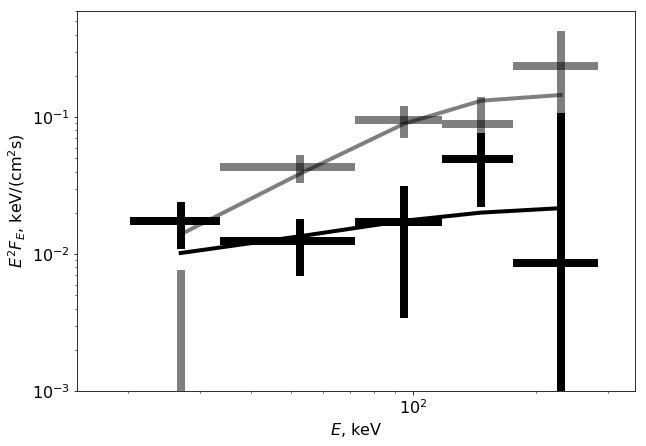

In [24]:
plt.figure(figsize=(10,7))

spectrum=np.genfromtxt(name+'_spectrum.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='black',alpha=1)
plt.plot(en,mo,color='black',linewidth=4)

spectrum=np.genfromtxt(name+'_flare_spectrum.txt',skip_header=3)
en=spectrum[:,0]
en_err=spectrum[:,1]
fl=spectrum[:,2]
fl_err=spectrum[:,3]
mo=spectrum[:,4]
plt.errorbar(en,fl,xerr=en_err,yerr=fl_err,linestyle='none',linewidth=8,color='black',alpha=0.5)
plt.plot(en,mo,color='black',linewidth=4,alpha=0.5)


plt.tick_params(axis='both', which='major', labelsize=16)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1.e-3,6.e-1)
plt.xlim(15,350)
plt.xlabel('$E$, keV',fontsize=16)
plt.ylabel('$E^2F_E$, keV/(cm$^2$s)',fontsize=16)
plt.savefig(name+'_spectra.pdf',format='pdf',dpi=100)




In [25]:
spectrum_3C279=name+'_spectrum.pdf'